In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [82]:
INPUT_PATH = '../data/credit_card_clients.csv'
data = pd.read_csv(INPUT_PATH)

data.rename(columns={'default payment next month': 'target'}, inplace=True)
data.drop(["ID"], axis=1, inplace=True)

# display("Total rows: " + str(len(data)))
# display("Columns: " + ", ".join(list(map(str, data.columns))))
# display(data.head())
# display(data.describe())

In [83]:
y = data['target'].copy()
X = data.copy()
X.drop(['target'], axis=1, inplace=True)

In [84]:
scaler =  StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [ ]:
fig, axes = plt.subplots(4, 6, figsize=(20, 13))

for i in range(len(X.columns)):
    sb.kdeplot(ax=axes[i//6, i%6], data=X[y == 0][X.columns[i]])
    sb.kdeplot(ax=axes[i//6, i%6], data=X[y == 1][X.columns[i]])

plt.tight_layout()
plt.show()

# MDC

### MDC With Euclidean Distance

In [187]:
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

In [202]:
MDC = NearestCentroid(metric='euclidean')
MDC.fit(X_train, y_train)

predictions = MDC.predict(X_test)
print("       F1_score:", f1_score(predictions, y_test))
print(" Accuracy_score:", accuracy_score(predictions, y_test))
print("   Recall_score:", recall_score(predictions, y_test))
print("Precision_score:", precision_score(predictions, y_test))

       F1_score: 0.4381720430107527
 Accuracy_score: 0.6516666666666666
   Recall_score: 0.340576681989135
Precision_score: 0.6141672946495855


### MDC With Mahalanobis Distance

In [213]:
class MinimumDistanceClassifierMahalanobis:
    def __init__(self):
        self.centroids = {}
        self.covariances = {}

    def fit(self, X_train, y_train):
        self.centroids = {c: X_train[y_train == c].mean() for c in np.unique(y_train)}
        self.covariances = {c: X_train[y_train == c].cov() for c in np.unique(y_train)}

    def predict(self, X_test):
        predictions = [
            min(
                self.centroids.keys(),
                key=lambda c: np.sqrt((x - self.centroids[c]) @ np.linalg.inv(self.covariances[c]) @ (x - self.centroids[c]))
            )
            for _, x in X_test.iterrows()
        ]
        return predictions
    
    def get_key(self):
        return self.centroids.keys()

In [219]:
MMDC = MinimumDistanceClassifierMahalanobis()
MMDC.fit(X_train, y_train)

predictions = MMDC.predict(X_test)
print("       F1_score:", f1_score(predictions, y_test))
print(" Accuracy_score:", accuracy_score(predictions, y_test))
print("   Recall_score:", recall_score(predictions, y_test))
print("Precision_score:", precision_score(predictions, y_test))

       F1_score: 0.46040334481062467
 Accuracy_score: 0.6343333333333333
   Recall_score: 0.3417305585980285
Precision_score: 0.7053504144687265


# PCA

In [170]:
pca = PCA(n_components=7)
pca.fit(X)
X_pca = pd.DataFrame(pca.transform(X))

In [171]:
SEED = 42
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y, test_size=0.2, random_state=SEED, stratify=y)

In [172]:
MDC = NearestCentroid()
MDC.fit(X_pca_train, y_pca_train)

predictions_pca = MDC.predict(X_pca_test)
print("       F1_score:", f1_score(predictions_pca, y_pca_test))
print(" Accuracy_score:", accuracy_score(predictions_pca, y_pca_test))
print("   Recall_score:", recall_score(predictions_pca, y_pca_test))
print("Precision_score:", precision_score(predictions_pca, y_pca_test))

       F1_score: 0.42816166883963497
 Accuracy_score: 0.6345
   Recall_score: 0.3273524720893142
Precision_score: 0.6186887716654107


### Explained PCA

This is the test I did to get the previous information about the dimensionality.

In [177]:
exp_pca = PCA(n_components=X.shape[1])
exp_pca.fit(X)

PCA(n_components=23)

In [178]:
eigenvalue = pd.DataFrame(exp_pca.explained_variance_ratio_)
index_lambda = []
preserved_variance = []
for i in range(eigenvalue.shape[0]):
    index_lambda.append(i)
    preserved_variance.append(eigenvalue[0][index_lambda].pow(2).sum() / eigenvalue[0].pow(2).sum() * 100)
index_lambda = pd.DataFrame(index_lambda)
preserved_variance = pd.DataFrame(preserved_variance)

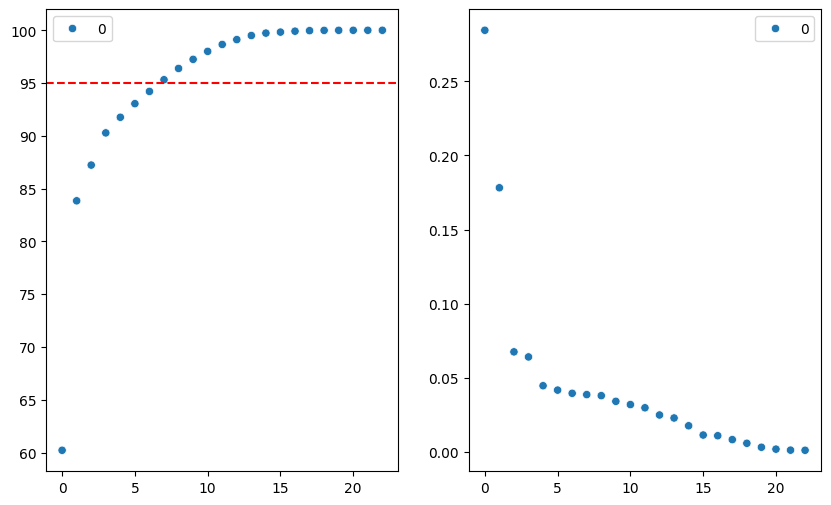

In [179]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))
sb.scatterplot(ax=axes[0], data=preserved_variance)
axes[0].axhline(y=95, color='r', linestyle='--')
sb.scatterplot(ax=axes[1], data=eigenvalue)
plt.show()

In [183]:
X_projected = X.dot(exp_pca.components_[range(8)].T)

In [184]:
SEED = 42
X_proj_train, X_proj_test, y_proj_train, y_proj_test = train_test_split(X_pca, y, test_size=0.2, random_state=SEED, stratify=y)

In [185]:
MDC = NearestCentroid()
MDC.fit(X_proj_train, y_proj_train)

predictions_lda = MDC.predict(X_proj_test)
print("       F1_score:", f1_score(predictions_lda, y_proj_test))
print(" Accuracy_score:", accuracy_score(predictions_lda, y_proj_test))
print("   Recall_score:", recall_score(predictions_lda, y_proj_test))
print("Precision_score:", precision_score(predictions_lda, y_proj_test))

       F1_score: 0.42816166883963497
 Accuracy_score: 0.6345
   Recall_score: 0.3273524720893142
Precision_score: 0.6186887716654107


# LDA

In [220]:
LDA = LinearDiscriminantAnalysis()
LDA.fit(X, y)

X_lda = LDA.transform(X)

In [221]:
SEED = 42
X_lda_train, X_lda_test, y_lda_train, y_lda_test = train_test_split(X_lda, y, test_size=0.2, random_state=SEED, stratify=y)

In [232]:
MDC = NearestCentroid()
MDC.fit(X_lda_train, y_lda_train)

predictions_lda = MDC.predict(X_lda_test)
print("       F1_score:", f1_score(predictions_lda, y_lda_test))
print(" Accuracy_score:", accuracy_score(predictions_lda, y_lda_test))
print("   Recall_score:", recall_score(predictions_lda, y_lda_test))
print("Precision_score:", precision_score(predictions_lda, y_lda_test))

       F1_score: 0.4897333741955256
 Accuracy_score: 0.7225
   Recall_score: 0.41270661157024796
Precision_score: 0.6021100226073851


### Calculate the Error

In [260]:
error = {
    'f1_score': [],
    'accuracy_score': [],
    'recall_score': [],
    'precision_score': []
}

for i in range(30):
    LDA = LinearDiscriminantAnalysis()
    LDA.fit(X, y)
    X_lda = LDA.transform(X)

    X_lda_train, X_lda_test, y_lda_train, y_lda_test = train_test_split(X_lda, y, test_size=0.2, random_state=i, stratify=y)

    MDC = NearestCentroid()
    MDC.fit(X_lda_train, y_lda_train)
    predictions_lda = MDC.predict(X_lda_test)
    
    error["f1_score"].append(f1_score(predictions_lda, y_lda_test))
    error["accuracy_score"].append(accuracy_score(predictions_lda, y_lda_test))
    error["recall_score"].append(recall_score(predictions_lda, y_lda_test))
    error["precision_score"].append(precision_score(predictions_lda, y_lda_test))

In [261]:
error = pd.DataFrame(error, columns=error.keys())

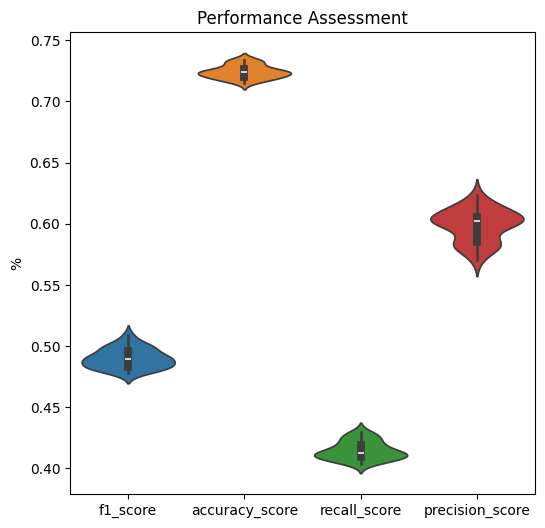

In [262]:
plt.figure(figsize=(6,6))

sb.violinplot(error)

plt.title("Performance Assessment")
plt.ylabel("%")
plt.show()